In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
import statsmodels.formula.api as smf
import numpy as np
%matplotlib inline

In [2]:
sentiment = pd.read_csv('consumer_sentiment.csv')

In [3]:
sentiment

,CASEID,YYYYMM,YYYYQ,YYYY,ID,IDPREV,DATEPR,ICS,ICC,ICE
0,1,197801,19781,1978,1,,,76.71,116.23,51.32
1,2,197801,19781,1978,2,,,121.12,154.08,99.94
2,3,197801,19781,1978,3,,,2.70,2.70,2.70
3,4,197801,19781,1978,4,,,76.71,154.08,27.01
4,5,197801,19781,1978,5,,,121.12,116.23,124.25
...,...,...,...,...,...,...,...,...,...,...
312726,312727,202307,20233,2023,2097,1130,202301,31.60,39.84,26.31
312727,312728,202307,20233,2023,2098,1038,202301,76.01,153.38,26.31
312728,312729,202307,20233,2023,2099,1141,202301,61.21,115.53,26.31
312729,312730,202307,20233,2023,2100,1071,202301,90.81,77.69,99.24


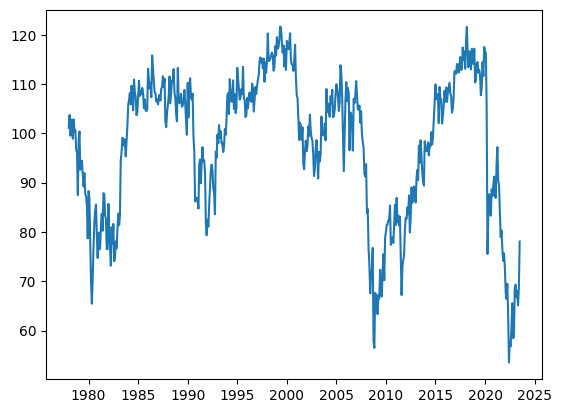

In [4]:
sentiment['DATE'] = pd.to_datetime(sentiment.YYYYMM, format="%Y%m")

sentiment_by_month = sentiment.groupby(['DATE']).ICC.mean()

plt.plot(sentiment_by_month)
plt.show()

In [5]:
unemployment = pd.read_csv("unemployment_rate.csv")
unemployment['DATE'] = pd.to_datetime(unemployment.DATE)
unemployment = unemployment.set_index('DATE')
inflation = pd.read_csv("inflation.csv")
inflation['DATE'] = pd.to_datetime(inflation.DATE)
inflation = inflation.set_index('DATE')
interest_rates = pd.read_csv("interest_rates.csv")
interest_rates['DATE'] = pd.to_datetime(interest_rates['DATE'])
interest_rates = interest_rates.set_index('DATE')

In [6]:
data = pd.DataFrame(data={"sentiment": sentiment_by_month, 
                          "inflation": inflation.CORESTICKM159SFRBATL, 
                          "unemployment": unemployment.UNRATE,
                          "rates": interest_rates.DFF}).dropna()

In [7]:
gdp = pd.read_csv('gdp.csv')
gdp['DATE'] = pd.to_datetime(gdp.DATE)
gdp = gdp.set_index('DATE')
gdp_growth = gdp.pct_change()
data['gdp_growth'] = gdp_growth.GDPC1
data = data.fillna(method="pad")

In [8]:
def norm(series):
    return (series-series.mean())/series.std()

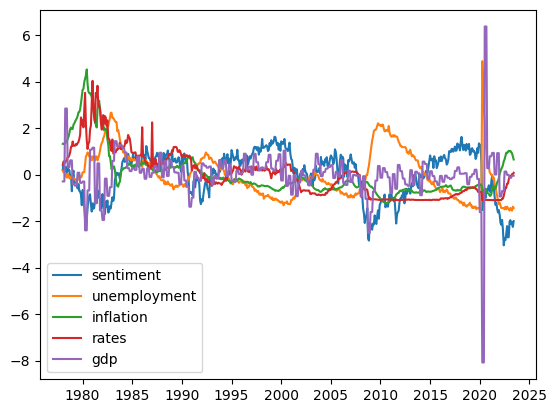

In [9]:
plt.plot(norm(data.sentiment))
plt.plot(norm(data.unemployment))
plt.plot(norm(data.inflation))
plt.plot(norm(data.rates))
plt.plot(norm(data.gdp_growth))
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates', 'gdp'])
plt.show()

In [10]:
def try_model(data, form):
    fig,axis = plt.subplots()
    data_precovid = data[data.index < '2020-02-01']
    model_80s = smf.ols(formula=form, data=data, subset=data.index < '1990').fit()
    model_precovid = smf.ols(formula=form, data=data, subset=data.index < '2020-02-01').fit()
    model_full = smf.ols(formula=form, data=data).fit()
    axis.plot(data.sentiment)
    for name, model in zip(["80s", "Pre-Covid", "Full"], [model_80s, model_precovid, model_full]):
        print(f"Model {name}")
        print(model.summary())
        plt.plot(model.predict(data))
    axis.axhline(y = 100, color='lightgrey')
    axis.legend(['sentiment', '80s', 'pre-covid', 'full', 'neutral'])
    plt.title(f"Model {form}")
    axis.set_ylim(50,150)
    plt.show()

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     326.0
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.33e-53
Time:                        12:43:37   Log-Likelihood:                -444.19
No. Observations:                 144   AIC:                             894.4
Df Residuals:                     141   BIC:                             903.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      149.0341      2.448    

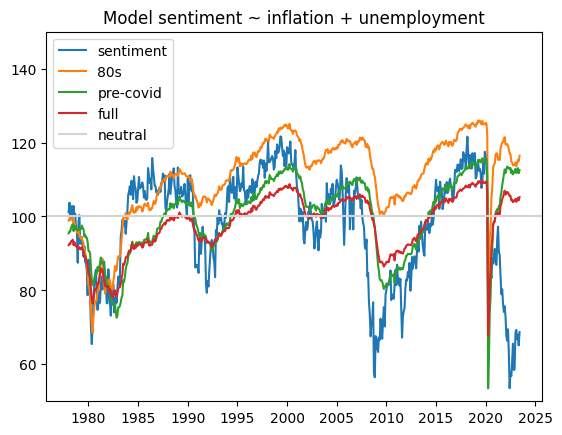

In [11]:
try_model(data, "sentiment ~ inflation + unemployment")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     227.4
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.30e-53
Time:                        12:43:38   Log-Likelihood:                -441.06
No. Observations:                 144   AIC:                             890.1
Df Residuals:                     140   BIC:                             902.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      149.2811      2.406    

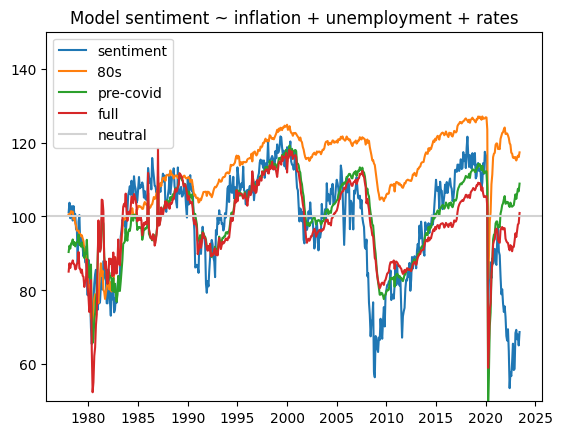

In [12]:
try_model(data, "sentiment ~ inflation + unemployment + rates")

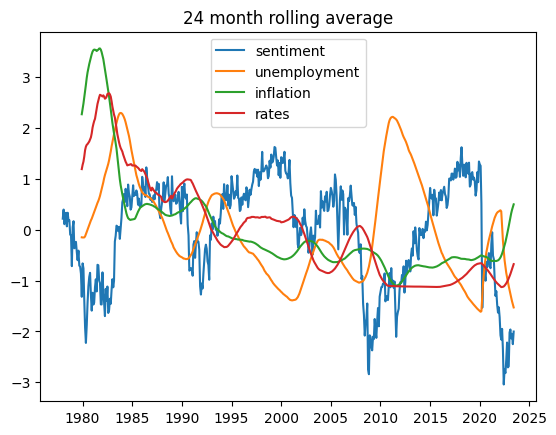

In [13]:
plt.plot(norm(data.sentiment))
plt.plot(norm(data.unemployment.rolling(24).mean()))
plt.plot(norm(data.inflation.rolling(24).mean()))
plt.plot(norm(data.rates.rolling(24).mean()))
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.title("24 month rolling average")
plt.show()

In [14]:
data['uenmployment_12_month'] = data.unemployment.rolling(12).mean()
data['inflation_12_month'] = data.inflation.rolling(12).mean()
data['rates_12_month'] = data.rates.rolling(12).mean()

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     142.4
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.18e-53
Time:                        12:43:38   Log-Likelihood:                -393.47
No. Observations:                 133   AIC:                             800.9
Df Residuals:                     126   BIC:                             821.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

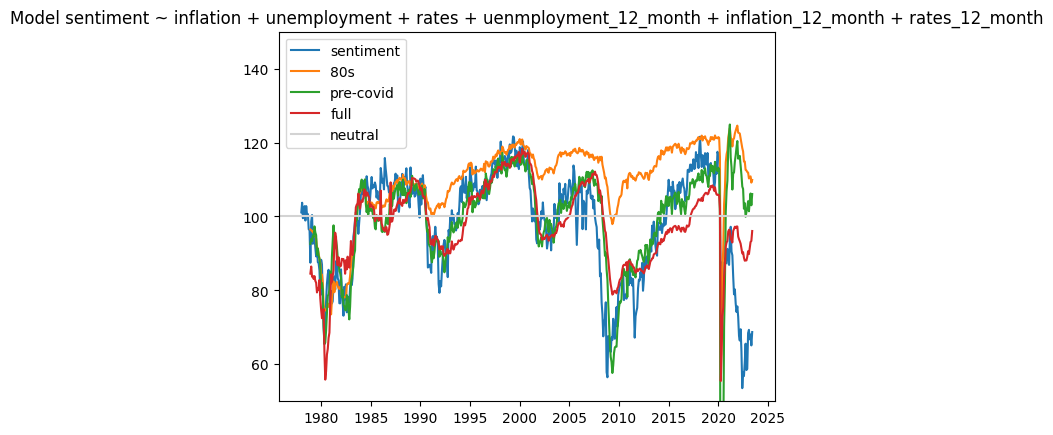

In [15]:
try_model(data, "sentiment ~ inflation + unemployment + rates + uenmployment_12_month + inflation_12_month + rates_12_month")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     168.1
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           3.37e-54
Time:                        12:43:39   Log-Likelihood:                -347.75
No. Observations:                 121   AIC:                             709.5
Df Residuals:                     114   BIC:                             729.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

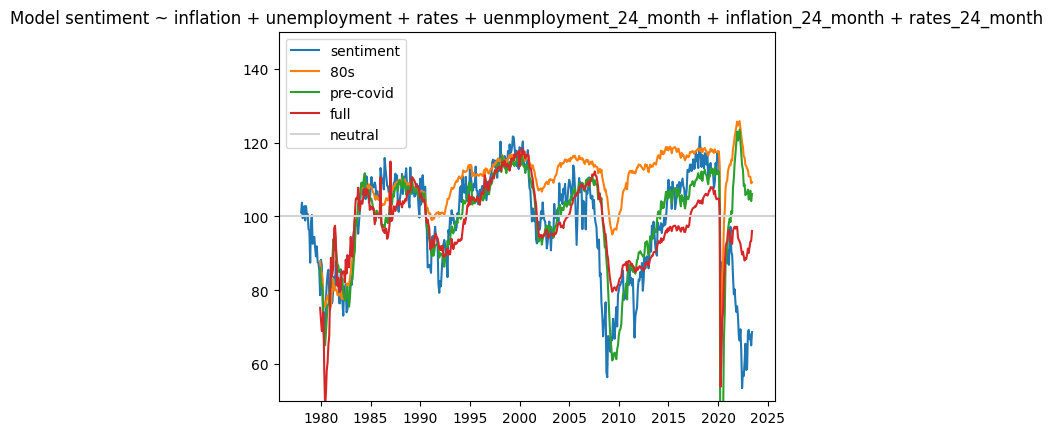

In [16]:
data['uenmployment_24_month'] = data.unemployment.rolling(24).mean()
data['inflation_24_month'] = data.inflation.rolling(24).mean()
data['rates_24_month'] = data.rates.rolling(24).mean()
try_model(data, "sentiment ~ inflation + unemployment + rates + uenmployment_24_month + inflation_24_month + rates_24_month")

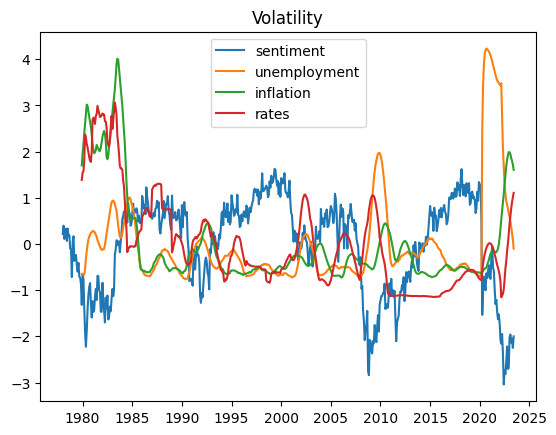

In [17]:
plt.plot(norm(data.sentiment))
plt.plot(norm(data.unemployment.rolling(24).std()))
plt.plot(norm(data.inflation.rolling(24).std()))
plt.plot(norm(data.rates.rolling(24).std()))
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.title("Volatility")
plt.show()

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     121.3
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           4.12e-47
Time:                        12:43:39   Log-Likelihood:                -365.15
No. Observations:                 121   AIC:                             744.3
Df Residuals:                     114   BIC:                             763.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

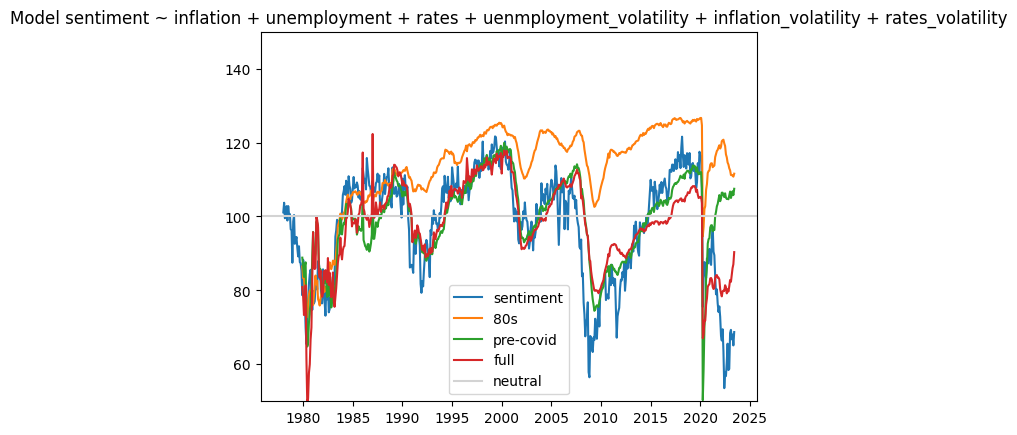

In [18]:
data['uenmployment_volatility'] = data.unemployment.rolling(24).std()
data['inflation_volatility'] = data.inflation.rolling(24).std()
data['rates_volatility'] = data.rates.rolling(24).std()
try_model(data,  "sentiment ~ inflation + unemployment + rates + uenmployment_volatility + inflation_volatility + rates_volatility")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     141.2
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.30e-43
Time:                        12:43:40   Log-Likelihood:                -379.05
No. Observations:                 121   AIC:                             768.1
Df Residuals:                     116   BIC:                             782.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

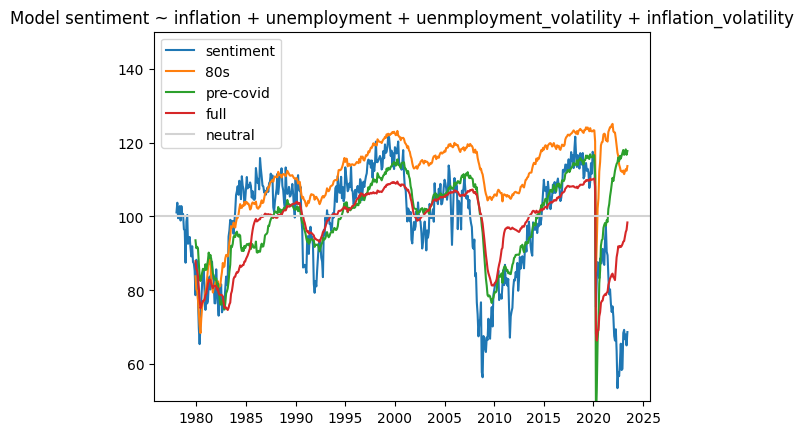

In [19]:
try_model(data,"sentiment ~ inflation + unemployment + uenmployment_volatility + inflation_volatility")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     106.8
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           4.37e-52
Time:                        12:43:40   Log-Likelihood:                -433.79
No. Observations:                 144   AIC:                             883.6
Df Residuals:                     136   BIC:                             907.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Interc

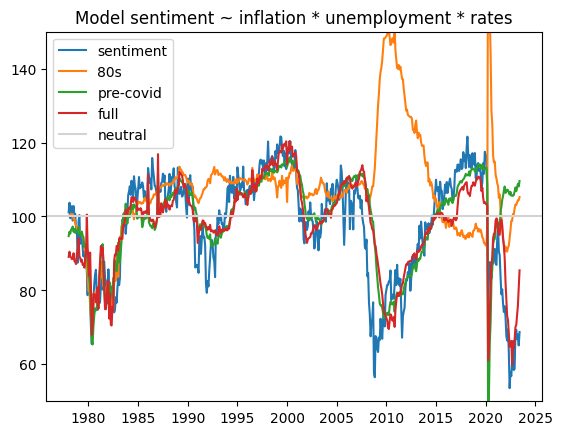

In [20]:
try_model(data, "sentiment ~ inflation * unemployment * rates")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     119.2
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           7.39e-52
Time:                        12:43:41   Log-Likelihood:                -436.94
No. Observations:                 144   AIC:                             887.9
Df Residuals:                     137   BIC:                             908.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

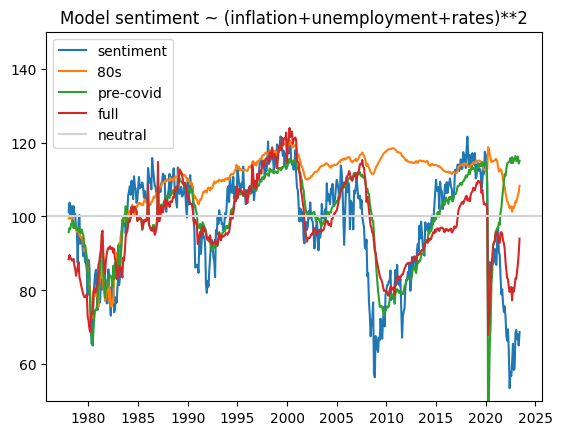

In [21]:
try_model(data, "sentiment ~ (inflation+unemployment+rates)**2")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     40.90
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.09e-31
Time:                        12:43:41   Log-Likelihood:                -254.21
No. Observations:                 121   AIC:                             636.4
Df Residuals:                      57   BIC:                             815.4
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     50.62
Date:                Tue, 08 Aug 2023   Prob (F-statistic):          2.14e-169
Time:                        12:43:41   Log-Likelihood:                -1610.6
No. Observations:                 523   AIC:                             3349.
Df Residuals:                     459   BIC:                             3622.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                                                                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

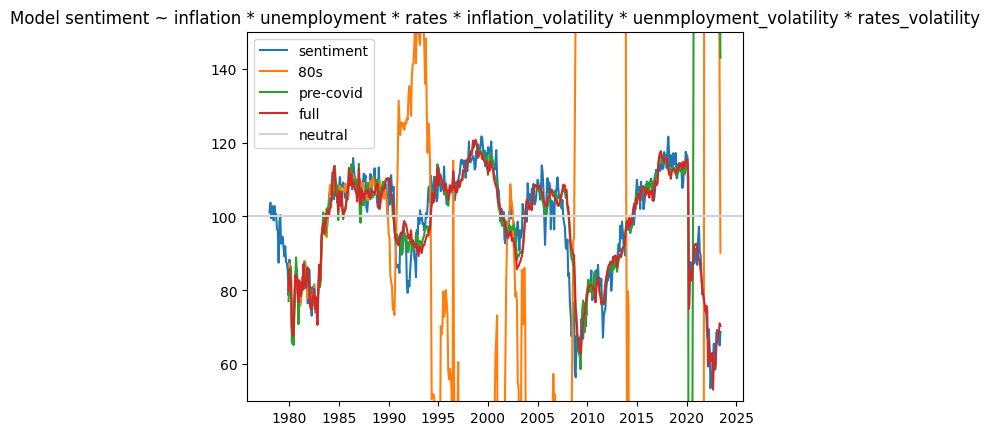

In [22]:
try_model(data, "sentiment ~ inflation * unemployment * rates * inflation_volatility * uenmployment_volatility * rates_volatility")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     76.18
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.27e-51
Time:                        12:43:42   Log-Likelihood:                -314.14
No. Observations:                 121   AIC:                             672.3
Df Residuals:                      99   BIC:                             733.8
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

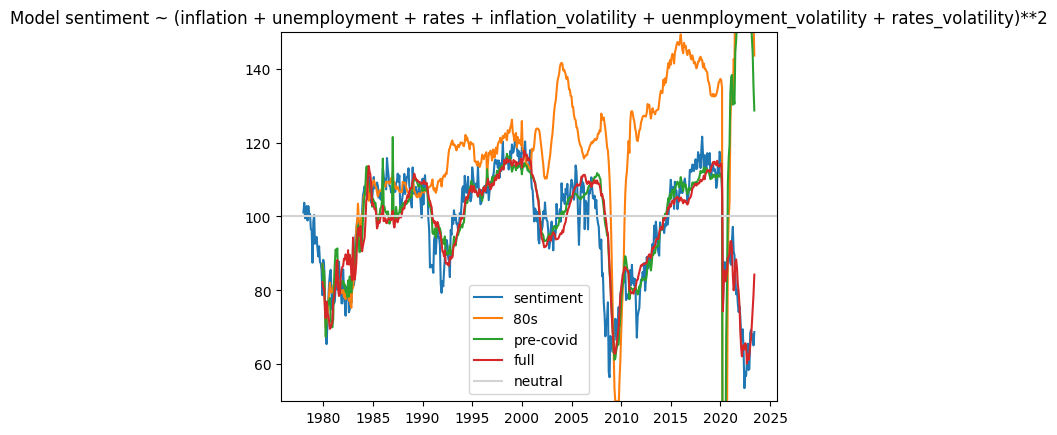

In [23]:
try_model(data, "sentiment ~ (inflation + unemployment + rates + inflation_volatility + uenmployment_volatility + rates_volatility)**2")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     128.4
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           7.26e-56
Time:                        12:43:42   Log-Likelihood:                -332.48
No. Observations:                 121   AIC:                             687.0
Df Residuals:                     110   BIC:                             717.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

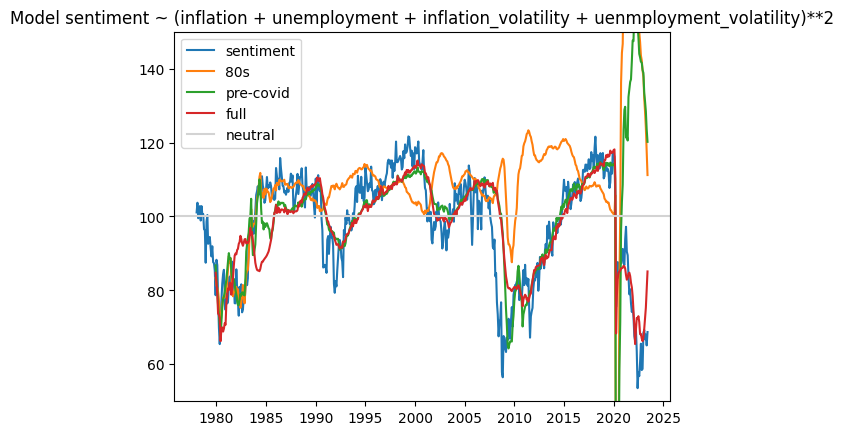

In [24]:
try_model(data, "sentiment ~ (inflation + unemployment + inflation_volatility + uenmployment_volatility)**2")

In [25]:
model = smf.ols(formula="sentiment ~ inflation + unemployment + rates + uenmployment_volatility + inflation_volatility + rates_volatility", data=data).fit()

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sentiment   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     136.2
Date:                Tue, 08 Aug 2023   Prob (F-statistic):          5.62e-103
Time:                        12:43:43   Log-Likelihood:                -1904.5
No. Observations:                 523   AIC:                             3823.
Df Residuals:                     516   BIC:                             3853.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 123.0065      1.734     70.951      0.000     119.601     126.412
inflation                  -4.0438      0.308    -13.116      0.000      -4.650      -3.438
unemployment               -2.4086      0.276     -8.713      0.000      -2.952      -1.865
rates                       2.7539      0.189     14.541      0.000       2.382       3.126
uenmployment_volatility    -4.3391      0.717     -6.055      0.000      -5.747      -2.931
inflation_volatility       -5.9819      1.076     -5.561      0.000      -8.095      -3.869
rates_volatility           -1.9664      0.878     -2.240      0.026      -3.691      -0.242
==============================================================================
Omnibus:                       36.996   Durbin-Watson:                   0.261
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.732
Skew:                          -0.622   Prob(JB):                     1.93e-10
Kurtosis:                       3.710   Cond. No.                         42.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

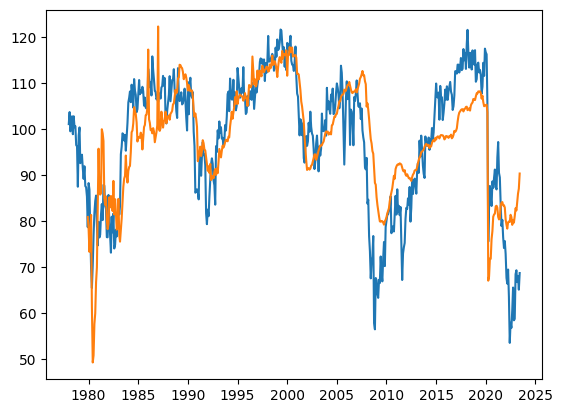

In [27]:
plt.plot(data.sentiment)
plt.plot(model.predict(data))
plt.show()

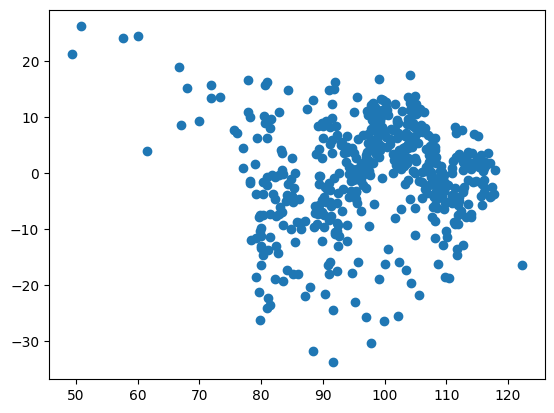

In [28]:
plt.scatter(x=model.fittedvalues, y=model.resid)

In [29]:
model = smf.ols(formula="np.log(sentiment) ~ inflation + unemployment + rates + uenmployment_volatility + inflation_volatility + rates_volatility", data=data).fit()

In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(sentiment)   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     123.1
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           3.46e-96
Time:                        12:43:43   Log-Likelihood:                 433.29
No. Observations:                 523   AIC:                            -852.6
Df Residuals:                     516   BIC:                            -822.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   4.8247      0.020    243.088      0.000       4.786       4.864
inflation                  -0.0449      0.004    -12.732      0.000      -0.052      -0.038
unemployment               -0.0223      0.003     -7.055      0.000      -0.029      -0.016
rates                       0.0309      0.002     14.251      0.000       0.027       0.035
uenmployment_volatility    -0.0492      0.008     -6.001      0.000      -0.065      -0.033
inflation_volatility       -0.0707      0.012     -5.744      0.000      -0.095      -0.047
rates_volatility           -0.0222      0.010     -2.206      0.028      -0.042      -0.002
==============================================================================
Omnibus:                       74.505   Durbin-Watson:                   0.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.815
Skew:                          -0.880   Prob(JB):                     7.89e-28
Kurtosis:                       4.622   Cond. No.                         42.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

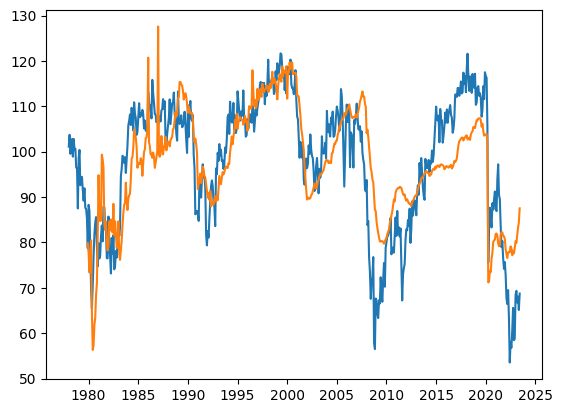

In [31]:
plt.plot(data.sentiment)
plt.plot(np.exp(model.predict(data)))

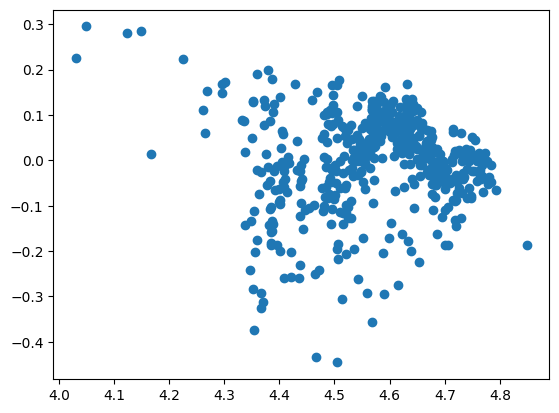

In [32]:
plt.scatter(x=model.fittedvalues, y=model.resid)

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     128.4
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           7.26e-56
Time:                        12:43:44   Log-Likelihood:                -332.48
No. Observations:                 121   AIC:                             687.0
Df Residuals:                     110   BIC:                             717.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

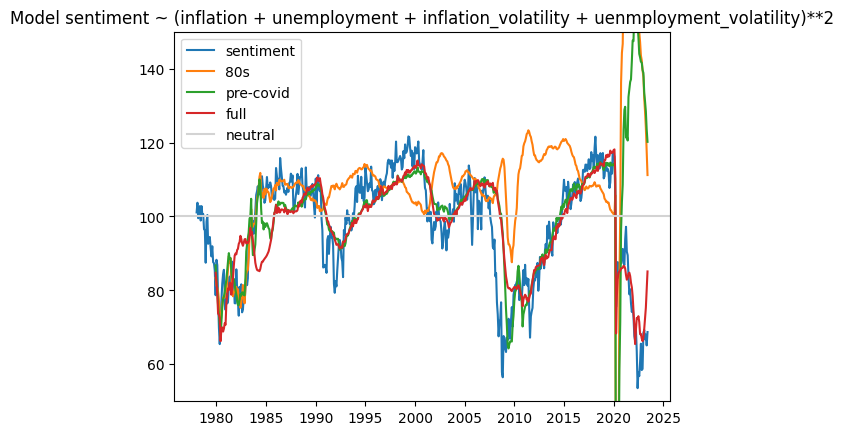

In [33]:
try_model(form="sentiment ~ (inflation + unemployment + inflation_volatility + uenmployment_volatility)**2", data=data)

In [34]:
model = smf.ols(formula="sentiment ~ (inflation + unemployment + inflation_volatility + uenmployment_volatility)**2", data=data).fit()

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sentiment   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     98.75
Date:                Tue, 08 Aug 2023   Prob (F-statistic):          1.19e-112
Time:                        12:43:44   Log-Likelihood:                -1871.7
No. Observations:                 523   AIC:                             3765.
Df Residuals:                     512   BIC:                             3812.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                      154.6383      3.909     39.560      0.000     146.959     162.318
inflation                                       -2.6624      1.468     -1.813      0.070      -5.547       0.223
unemployment                                    -9.7605      0.629    -15.513      0.000     -10.997      -8.524
inflation_volatility                           -18.0317      5.616     -3.211      0.001     -29.064      -6.999
uenmployment_volatility                        -13.1213      2.680     -4.897      0.000     -18.386      -7.857
inflation:unemployment                           0.8889      0.237      3.758      0.000       0.424       1.354
inflation:inflation_volatility                  -2.1663      0.306     -7.072      0.000      -2.768      -1.564
inflation:uenmployment_volatility               -1.6662      0.747     -2.231      0.026      -3.134      -0.199
unemployment:inflation_volatility                3.2507      0.723      4.497      0.000       1.831       4.671
unemployment:uenmployment_volatility             2.0760      0.292      7.106      0.000       1.502       2.650
inflation_volatility:uenmployment_volatility    -1.6886      3.600     -0.469      0.639      -8.761       5.384
==============================================================================
Omnibus:                       86.897   Durbin-Watson:                   0.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              213.348
Skew:                          -0.851   Prob(JB):                     4.70e-47
Kurtosis:                       5.625   Cond. No.                         509.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

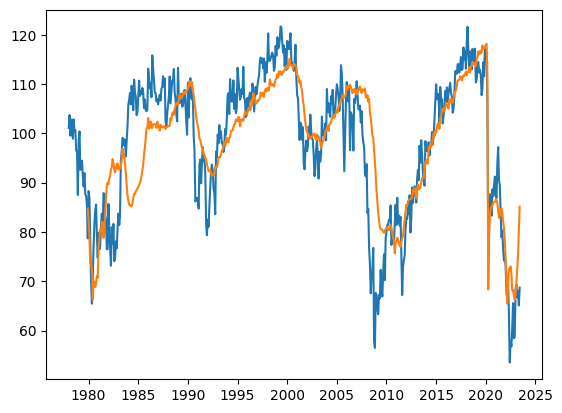

In [36]:
plt.plot(data.sentiment)
plt.plot(model.predict(data))

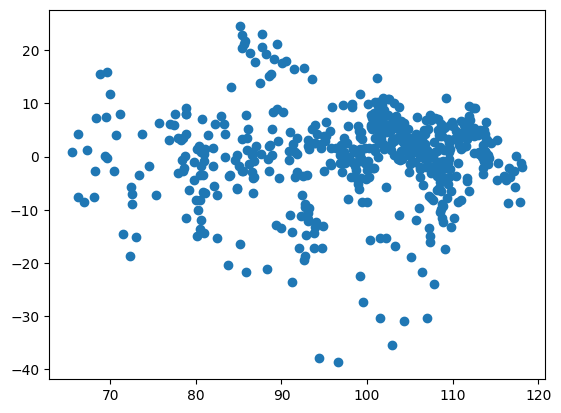

In [37]:
plt.scatter(x=model.fittedvalues, y=model.resid)

In [38]:
data['sentiment_move'] = data.sentiment - data.sentiment.rolling(12).mean()

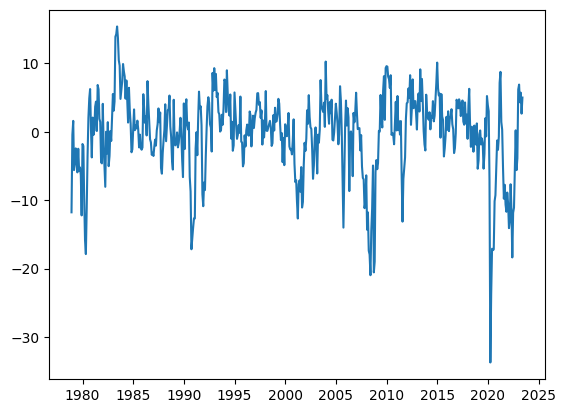

In [39]:
plt.plot(data.sentiment_move)

In [40]:
model = smf.ols(formula="sentiment_move ~ inflation * unemployment * rates", data=data).fit()

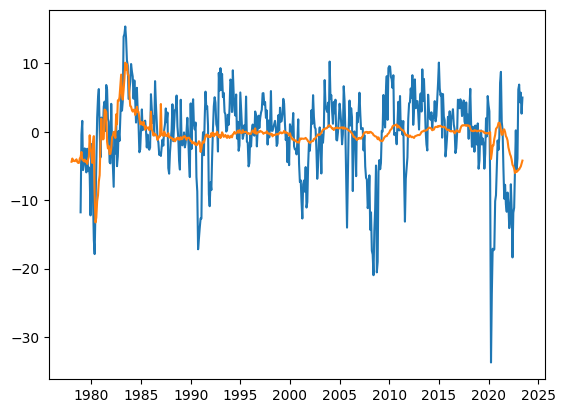

In [41]:
plt.plot(data.sentiment_move)
plt.plot(model.predict(data))

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sentiment_move   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     11.61
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           9.22e-14
Time:                        12:43:45   Log-Likelihood:                -1678.7
No. Observations:                 535   AIC:                             3373.
Df Residuals:                     527   BIC:                             3408.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        8.2446      2.846      2.896      0.004       2.653      13.836
inflation                       -2.2892      0.962     -2.381      0.018      -4.178      -0.400
unemployment                    -0.6833      0.395     -1.731      0.084      -1.459       0.092
inflation:unemployment           0.0841      0.145      0.580      0.562      -0.201       0.369
rates                           -2.2289      0.519     -4.296      0.000      -3.248      -1.210
inflation:rates                  0.3528      0.104      3.408      0.001       0.149       0.556
unemployment:rates               0.3847      0.074      5.188      0.000       0.239       0.530
inflation:unemployment:rates    -0.0448      0.014     -3.100      0.002      -0.073      -0.016
==============================================================================
Omnibus:                      105.978   Durbin-Watson:                   0.518
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.525
Skew:                          -1.046   Prob(JB):                     4.36e-52
Kurtosis:                       5.497   Cond. No.                     4.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     72.32
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           1.13e-43
Time:                        12:43:46   Log-Likelihood:                -361.92
No. Observations:                 121   AIC:                             745.8
Df Residuals:                     110   BIC:                             776.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

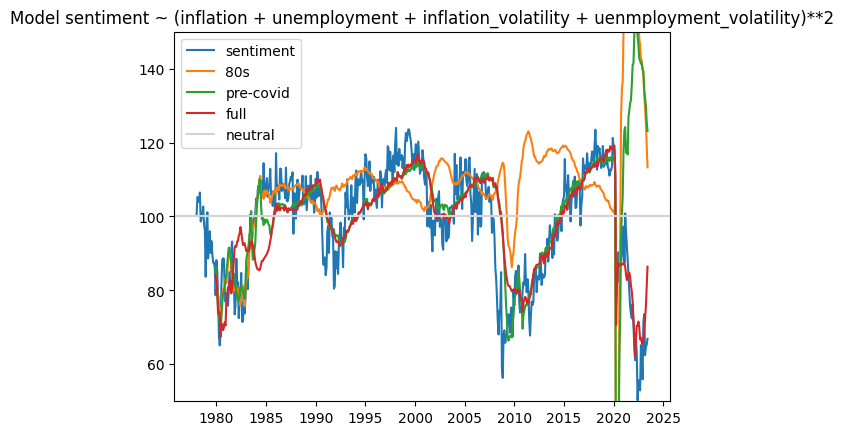

In [43]:
sentiment_by_region = pd.read_csv('consumer_sentiment_plus_region.csv', low_memory=False)

sentiment_by_region['DATE'] = pd.to_datetime(sentiment_by_region.YYYYMM, format="%Y%m")
sentiments = sentiment_by_region.groupby(['REGION', 'DATE']).ICC.mean()

regional_data = {}
for region in ['1', '2', '3', '4']:
    regional_data[region] = data.copy()
    regional_data[region]['sentiment'] = sentiments.loc[region]
try_model(form="sentiment ~ (inflation + unemployment + inflation_volatility + uenmployment_volatility)**2",
         data=regional_data['4'])

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     104.3
Date:                Tue, 08 Aug 2023   Prob (F-statistic):           7.07e-56
Time:                        12:43:46   Log-Likelihood:                -318.75
No. Observations:                 121   AIC:                             669.5
Df Residuals:                     105   BIC:                             714.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

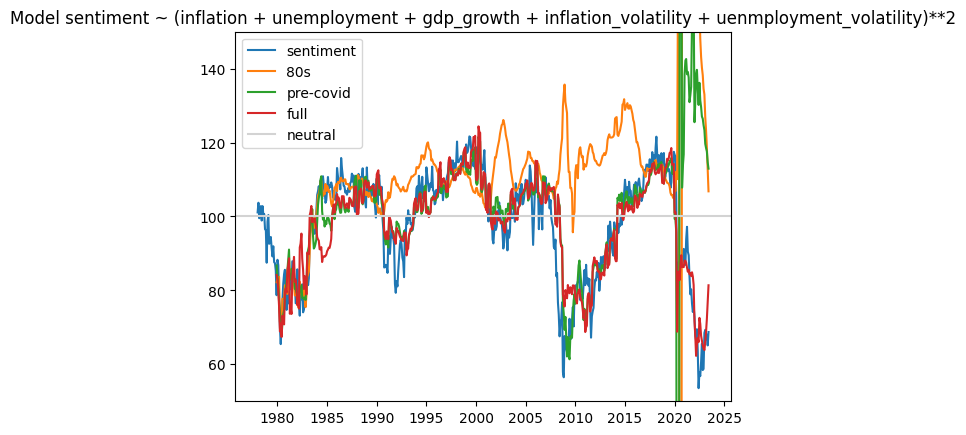

In [44]:
try_model(form="sentiment ~ (inflation + unemployment + gdp_growth + inflation_volatility + uenmployment_volatility)**2", data=data)